#### Compare Survey Race x Educational Attainment Data vs State Level Data 

Source: Census Population Survey, Annual Social and Economic Supplements 2023 

* [Data Page](https://www.census.gov/data/datasets/2023/demo/cps/cps-asec-2023.html)
* [Data Dictionary](https://www2.census.gov/programs-surveys/cps/datasets/2023/march/asec2023_ddl_pub_full.pdf)

---

In [94]:
import pandas as pd 
import os 
import numpy as np

df_hhpub23 = pd.read_csv(os.path.join(os.pardir, 'data', 'asecpub23csv', 'hhpub23.csv'))
df_pppub23 = pd.read_csv(os.path.join(os.pardir, 'data', 'asecpub23csv', 'pppub23.csv'))


In [95]:
## Relevant columns 
# GESTFIPS - state fips (hhpub)
# A_HGA - Educational Attainment (pppub)
# PRDTRACE - Race (pppub)
# H_IDNUM - Household ID (hhpub), 20 digits
# PERIDNUM - Person ID (pppub), 22 digits, first 20 same as a household
# A_FTPT - is enrolled in school as a full-time or part-time student (pppub) 
    # -- use for determining whether CPS high school grades map to "Currently in high school" or "Some high school, no diploma" for SurveyMonkey data

rel_columns = ["GESTFIPS", "A_HGA", "PRDTRACE", "H_IDNUM", "PERIDNUM", "A_FTPT"]

df_hh_filter = df_hhpub23.filter(regex="|".join(rel_columns)).drop_duplicates()
df_pp_filter = df_pppub23.filter(regex="|".join(rel_columns)).drop_duplicates()

In [96]:
print(df_hhpub23.shape, df_hh_filter.shape)
print(df_pppub23.shape, df_pp_filter.shape)

(88978, 140) (88978, 2)
(146133, 829) (146133, 4)


In [97]:
df_pp_filter['H_IDNUM'] = df_pp_filter['PERIDNUM'].str[:20]

In [98]:
for df in (df_pp_filter, df_hh_filter): 
    for col in df.columns: 
        df[col] = df[col].astype(str)
    print(df.dtypes)

PERIDNUM    object
PRDTRACE    object
A_FTPT      object
A_HGA       object
H_IDNUM     object
dtype: object
H_IDNUM     object
GESTFIPS    object
dtype: object


In [99]:
df_joined = df_pp_filter.merge(df_hh_filter, how='left', on='H_IDNUM')
df_joined = df_joined[df_joined['GESTFIPS'] == "11"]
df_joined

,PERIDNUM,PRDTRACE,A_FTPT,A_HGA,H_IDNUM,GESTFIPS
53207,2203970001835311511101,2,0,40,22039700018353115111,11
53208,0032101833092571511101,2,0,39,00321018330925715111,11
53209,3130802072351901511101,1,0,40,31308020723519015111,11
53210,3130502013491811511101,2,0,40,31305020134918115111,11
53211,4121009053331181511101,2,0,40,41210090533311815111,11
...,...,...,...,...,...,...
55082,5180461017501231611102,1,0,39,51804610175012316111,11
55083,0405310511776101611101,2,0,44,04053105117761016111,11
55084,7900415040715171611101,2,0,39,79004150407151716111,11
55085,1001210711746741611101,2,0,39,10012107117467416111,11


In [100]:
race_codes = { # from data dictionary 

    "01" : "White only",
    "02" : "Black only",
    "03" : "American Indian, Alaskan Native only (AI)",
    "04" : "Asian only",
    "05" : "Hawaiian/Pacific Islander only (HP)",
    "06" : "White-Black",
    "07" : "White-AI",
    "08" : "White-Asian",
    "09" : "White-HP",
    "10" : "Black-AI",
    "11" : "Black-Asian",
    "12" : "Black-HP",
    "13" : "AI-Asian",
    "14" : "AI-HP",
    "15" : "Asian-HP",
    "16" : "White-Black-AI",
    "17" : "White-Black-Asian",
    "18" : "White-Black-HP",
    "19" : "White-AI-Asian",
    "20" : "White-AI-HP",
    "21" : "White-Asian-HP",
    "22" : "Black-AI-Asian",
    "23" : "White-Black-AI-Asian",
    "24" : "White-AI-Asian-HP",
    "25" : "Other 3 race comb.",
    "26" : "Other 4 or 5 race comb.",

}

edu_codes = {

    "0" : "Children",
    "31"  : "Less than 1st grade",
    "32"  : "1st,2nd,3rd,or 4th grade",
    "33"  : "5th or 6th grade",
    "34"  : "7th and 8th grade",
    "35"  : "9th grade",
    "36"  : "10th grade",
    "37"  : "11th grade",
    "38"  : "12th grade no diploma",
    "39"  : "High school graduate - high school diploma or equivalent",
    "40"  : "Some college but no degree",
    "41"  : "Associate degree in college - occupation/vocation program",
    "42"  : "Associate degree in college - academic program",
    "43"  : "Bachelor's degree (for example: BA,AB,BS)",
    "44"  : "Master's degree (for example: MA,MS,MENG,MED,MSW, MBA)",
    "45"  : "Professional school degree (for example: MD,DDS,DVM,LLB,JD)",
    "46"  : "Doctorate degree (for example: PHD,EDD)",

}

enrollment_codes = { # A_FTPT

    "0" : "Not in universe or children and Armed Forces",
    "1" : "Full time", 
    "2" : "Part time",
}

Simplify codes to match SurveyMonkey Survey

In [101]:

## Before simplifying, looking at racial breakdown in DE for the CPS 
# race_simplify = { # Main SurveyMonkey comparison was black vs white since all other groups were small in number (N=29 vs 299).  

#     "01" : "White only",
#     "02" : "Black only",
#     ""
#     }

In [102]:
fp = os.path.join(os.pardir, 'data', 'response', 'What is the highest level of education that you have attained?_Response_n=288.csv')
df_edu = pd.read_csv(fp, index_col=0)
sm_edu_cats = list(df_edu.iloc[:, 0].unique())
display(sm_edu_cats) 

edu_simplify = {

    # "9th grade":"Some high school" ## Also need to check vs the person's age 
    # "10th grade":"Some high school"
    # "11th grade":"Some high school"
    # "12th grade no diploma":"Some high school"

    "High school graduate - high school diploma or equivalent":"High school graduate", 
    # Keep the Same --  doesn't disambiguate vs GED and diploma like SurveyMonkey
    
    "Some college but no degree":"Some college, no degree", 
    "Associate degree in college - occupation/vocation program":"Associate's degree", 
    "Associate degree in college - academic program":"Associate's degree", 
    "Bachelor's degree (for example: BA,AB,BS)":"Bachelor's degree", 
    "Master's degree (for example: MA,MS,MENG,MED,MSW, MBA)":"Master's or higher degree", 
    "Professional school degree (for example: MD,DDS,DVM,LLB,JD)":"Master's or higher degree",
    "Doctorate degree (for example: PHD,EDD)":"Master's or higher degree" 

}

['High school diploma',
 "Master's or higher degree",
 "Bachelor's degree",
 'Some college, no degree',
 "Associate's degree",
 'Some high school, no diploma',
 'GED',
 'Currently attending high school']

Simplifying Education 

In [103]:
df_joined['A_HGA'] = df_joined['A_HGA'].astype(str)
df_joined['A_HGA_edu_cat'] = df_joined['A_HGA'].apply(lambda x: edu_codes[x]) 
# df_joined['A_HGA_edu_simplify'] = df_joined

def simplify_edu(row): 
    # Use dictionary for qualifying categories
    if row['A_HGA_edu_cat'] in (edu_simplify.keys()): 
        return edu_simplify[row['A_HGA_edu_cat']]
    
    # If a high school grade 
    elif row['A_HGA_edu_cat'] in [f"{n}th grade" for n in range(9, 12)] + ['12th grade no diploma']:

        if row['A_FTPT'] in ("1", "2"): # Full or part time student
            return "Currently attending high school"
        
        else: # Unenrolled  
            return "Some high school, no diploma"
        
    # If not in recognized cats or a high school grade 
    else: 
        return "Other"

df_joined['A_HGA_edu_simple'] = df_joined.apply(lambda row: simplify_edu(row), axis=1) 
df_joined

,PERIDNUM,PRDTRACE,A_FTPT,A_HGA,H_IDNUM,GESTFIPS,A_HGA_edu_cat,A_HGA_edu_simple
53207,2203970001835311511101,2,0,40,22039700018353115111,11,Some college but no degree,"Some college, no degree"
53208,0032101833092571511101,2,0,39,00321018330925715111,11,High school graduate - high school diploma or ...,High school graduate
53209,3130802072351901511101,1,0,40,31308020723519015111,11,Some college but no degree,"Some college, no degree"
53210,3130502013491811511101,2,0,40,31305020134918115111,11,Some college but no degree,"Some college, no degree"
53211,4121009053331181511101,2,0,40,41210090533311815111,11,Some college but no degree,"Some college, no degree"
...,...,...,...,...,...,...,...,...
55082,5180461017501231611102,1,0,39,51804610175012316111,11,High school graduate - high school diploma or ...,High school graduate
55083,0405310511776101611101,2,0,44,04053105117761016111,11,"Master's degree (for example: MA,MS,MENG,MED,M...",Master's or higher degree
55084,7900415040715171611101,2,0,39,79004150407151716111,11,High school graduate - high school diploma or ...,High school graduate
55085,1001210711746741611101,2,0,39,10012107117467416111,11,High school graduate - high school diploma or ...,High school graduate


In [104]:
df_joined['A_HGA_edu_simple'].value_counts()

A_HGA_edu_simple
Master's or higher degree          659
Bachelor's degree                  428
Other                              301
High school graduate               192
Some college, no degree            131
Some high school, no diploma        76
Currently attending high school     51
Associate's degree                  42
Name: count, dtype: int64

Simplifying Race 

In [105]:
df_joined['PRDTRACE_race_cats'] = df_joined['PRDTRACE'].str.zfill(2).apply(lambda x: race_codes[x] if x in race_codes.keys() else np.nan)
any(df_joined['PRDTRACE_race_cats'].isna())

False

In [106]:
df_joined['PRDTRACE_race_cats'].value_counts() # Will group the non white only, non black only categories into "Other" and exclude these
# White-Black only has 12 

PRDTRACE_race_cats
White only                                   1009
Black only                                    685
Asian only                                    117
White-Asian                                    17
American Indian, Alaskan Native only (AI)      13
White-Black                                    12
Black-AI                                        9
Black-Asian                                     4
White-HP                                        4
Asian-HP                                        2
Hawaiian/Pacific Islander only (HP)             2
White-Black-AI                                  2
White-AI                                        2
White-Asian-HP                                  1
Black-HP                                        1
Name: count, dtype: int64

In [107]:
display(df_joined.shape)
df_joined = df_joined[df_joined['PRDTRACE_race_cats'].isin(['White only', 'Black only'])] # drop other race cats
display(df_joined.shape)
df_joined = df_joined[df_joined['A_HGA_edu_simple'] != "Other"] # drop other education levels
display(df_joined.shape)


(1880, 9)

(1694, 9)

(1430, 9)

,Education Level,count
0,High school graduate,152
1,Bachelor's degree,107
2,Master's or higher degree,107
3,"Some college, no degree",100
4,"Some high school, no diploma",56
5,Associate's degree,31
6,Currently attending high school,17


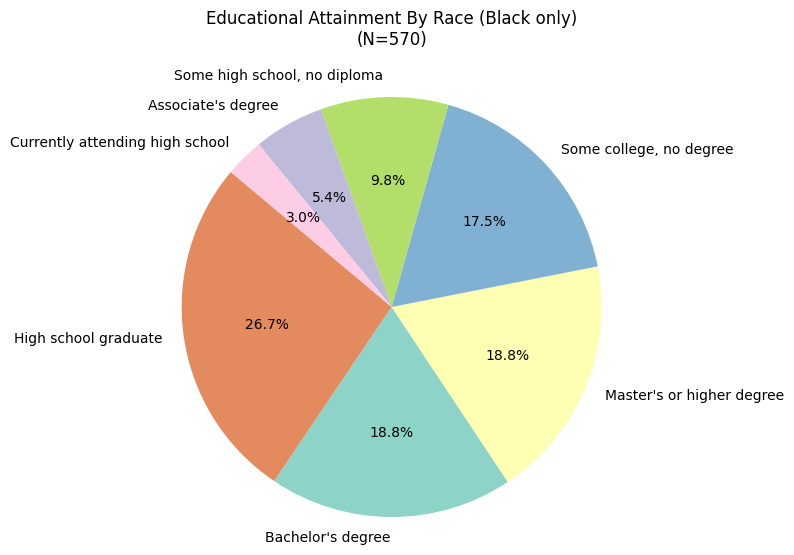

,Education Level,count
0,Master's or higher degree,471
1,Bachelor's degree,289
2,High school graduate,29
3,Currently attending high school,27
4,"Some college, no degree",22
5,"Some high school, no diploma",14
6,Associate's degree,8


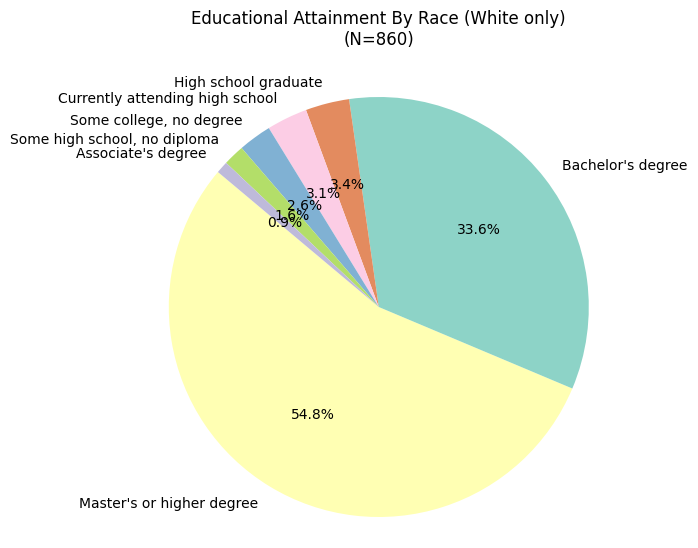

In [111]:
import sys 
sys.path.append(os.pardir)
from modules.plotting import plot_pie_chart

color_palette = [
'#8dd3c7',
'#ffffb3',
'#bebada',
'#fb8072',
'#80b1d3',
'#fdb462',
'#b3de69',
'#e38b5f'
]


# edu_levels = list(df_joined['A_HGA_edu_simple'].unique())
# display(edu_levels)

edu_levels = [
 'Currently attending high school',
 'Some high school, no diploma'
 'High school graduate', # eq. to either GED or High School diploma in Survey Monkey
 'Some college, no degree',
 "Bachelor's degree",
 'Other',
 "Master's or higher degree",
 "Associate's degree",
 ]

# color_map = dict(zip(edu_levels, color_palette))
# display(color_map)

color_map = {
 'Currently attending high school': '#fccde5',
 'Some high school, no diploma': '#b3de69',
#  'High school diploma': '#fb8072',
#  'GED': '#fdb462',
 "High school graduate": "#e38b5f", # approx. midway point 

 'Some college, no degree': '#80b1d3',
 "Associate's degree": '#bebada',
 "Bachelor's degree": '#8dd3c7',
 "Master's or higher degree": '#ffffb3',
 }

for race in ('Black only', 'White only'):
    data = df_joined[df_joined['PRDTRACE_race_cats'] == race]
    v_counts = data['A_HGA_edu_simple'].value_counts().reset_index().rename({"A_HGA_edu_simple":'Education Level'}, axis=1)
    display(v_counts)
    title = f"Educational Attainment By Race ({race})\n(N={data.shape[0]})"
    plot_pie_chart(v_counts, label_column='Education Level', count_column='count', title=title, color_map=color_map)


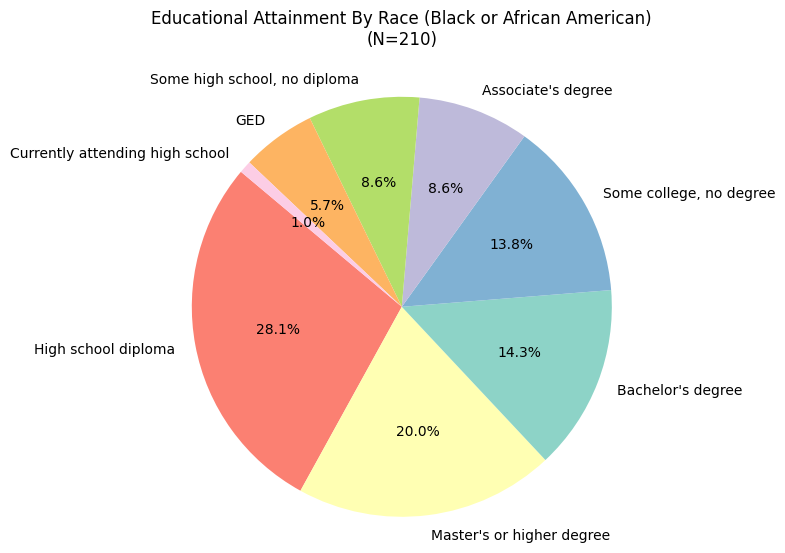

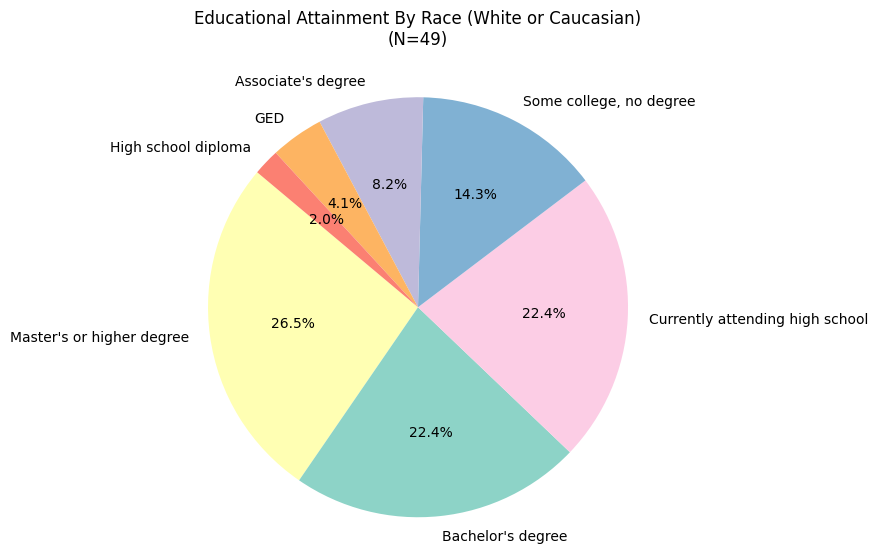

In [109]:
from PIL import Image 
# For github rendering
img_fp = os.path.join(os.pardir, 'img', 'sm_survey_black_education.png')
img = Image.open(img_fp)
display(img)

img_fp = os.path.join(os.pardir, 'img', 'sm_survey_white_education.png')
img = Image.open(img_fp)
display(img)

